In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower

In this notebook, we will train our iterative emulator on a simple scenario of linear Power spectrum, i.e, we assume that our data vector is a binned _linear_ power spectrum, $P(k)$. 

We will use our neural network emulator to predict the power spectrum as a function of cosmology. 

We use `camb` to predict the linear power spectrum, binned in $k$ bins as defined below. 

In [2]:
def get_Pk(cosmo_pars):
    As, ns, H0, ombh2, omch2 = cosmo_pars
    #Now get matter power spectra and sigma8 at redshift 0 and 0.8
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(As=As, ns=ns)
    #Note non-linear corrections couples to smaller scales than you want
    pars.set_matter_power(redshifts=[0.], kmax=2.0)

    #Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-3, maxkh=1, npoints = 2000)
    s8 = np.array(results.get_sigma8())
    
    return kh, pk[0], s8

In [3]:
# We use 21 logarithmically spaced k bins between 0.01 h/Mpc to 0.1 h/Mpc for our inference

k_min = 0.01
k_max = 0.1
N_bins = 21

k_bins = np.logspace(np.log10(k_min), np.log10(k_max), N_bins)

In [4]:
# Functions to get the binned linear power spectra.

from scipy.interpolate import interp1d
from scipy.integrate import quad

EPS_REL = 1e-4

def integration_numerator(u, pk_interp):
    kh = np.exp(u)
    jacobian = kh
    return pk_interp(kh) * kh * kh * jacobian

def integration_denominator(u):
    kh = np.exp(u)
    jacobian = kh
    return kh * kh * jacobian

def integration_k_bincentre(u):
    kh = np.exp(u)
    jacobian = kh
    return kh * kh * kh * jacobian

def get_binned_Pk(kh, pk, k_bins):
    pk_interp = interp1d(kh, pk)
    binned_Pk_list = []
    binned_k_list = []
    for i in range(len(k_bins) - 1):
        u_lo = np.log(k_bins[i])
        u_hi = np.log(k_bins[i+1])
        I_n, _ = quad(integration_numerator, u_lo, u_hi, epsrel=EPS_REL, args=(pk_interp,))
        I_d, _ = quad(integration_denominator, u_lo, u_hi, epsrel=EPS_REL)
        I_k, _ = quad(integration_k_bincentre, u_lo, u_hi, epsrel=EPS_REL)
        
        Pk_i = I_n / I_d
        k_i  = I_k / I_d
        
        binned_Pk_list.append(Pk_i)
        binned_k_list.append(k_i)
        
    return np.array(binned_k_list), np.array(binned_Pk_list)

To use the emulator, we need a function to compute the data vector as a function of cosmological parameters. 

For your specific case, you can simply replace this function along with the log probability function to use the emulator as proposed here.

In [ ]:
def compute_datavector(cosmo_pars):
    kh, pk, _ = get_Pk(cosmo_pars)
    _, Pk_binned = get_binned_Pk(kh, pk, k_bins)
    return Pk_binned

In [ ]:
# We use the following fiducial parameters in our analysis

cosmo_pars_fid = np.array([2e-9, 0.97, 70., 0.0228528, 0.1199772])

kh_fid, pk_fid, _ = get_Pk(cosmo_pars_fid)
binned_k, binned_Pk_fid = get_binned_Pk(kh_fid, pk_fid, k_bins)

The (Gaussian) covariance for the 3D power spectrum is given in equation (4) of https://arxiv.org/pdf/astro-ph/9901099.pdf

In [6]:
delta_k = (k_bins[1:] - k_bins[:-1])
# We assume a volume of NGC-High-z chunk (See eqn A8 of https://arxiv.org/pdf/2009.00622.pdf)
V = 2.78 * 10**9      
Pk_cov = 4 * np.pi**2 * binned_Pk_fid**2 / binned_k**2 / delta_k / V

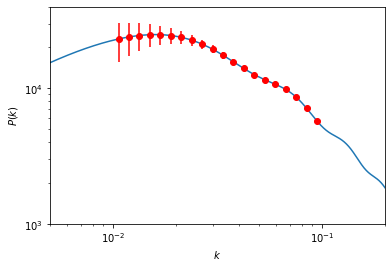

In [9]:
plt.xlim(5e-3, 2e-1)
plt.ylim(1e+3, 4e+4)
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.loglog(kh_fid, pk_fid)
plt.errorbar(binned_k, binned_Pk_fid, np.sqrt(Pk_cov), color='r', fmt='o')
plt.show()

## Initialize a Latin Hypercube

We begin our emulator training, we need a Latin Hypercube sample with the prior range.

In [10]:
from pyDOE import lhs

N_dim = 5

cosmo_prior = np.array([[1.2e-9, 2.7e-9],
                       [0.87, 1.07],
                       [55, 91],
                       [0.01, 0.04],
                       [0.002, 0.5]])

def get_cosmo_lhs_samples(N_samples, cosmo_prior):
    lhs_samples = lhs(N_dim, N_samples)
    cosmo_samples = cosmo_prior[:,0] + (cosmo_prior[:,1] - cosmo_prior[:,0]) * lhs_samples
    return cosmo_samples

In [11]:
N_lhs_samples = 100

train_cosmo_samples = get_cosmo_lhs_samples(N_lhs_samples, cosmo_prior)

In [12]:
from tqdm import tqdm
from multiprocessing import Pool

def calculate_datavector_batch(train_cosmo_samples):
    """
    Function to calculate the data vectors for a batch of training samples
    """
    train_dv_list = []
    with Pool() as p:
        train_dv_list = list(tqdm(p.imap(compute_datavector, train_cosmo_samples), total=len(train_cosmo_samples)))
    return np.array(train_dv_list)    

In [13]:
train_dv_arr = calculate_datavector_batch(train_cosmo_samples)

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


## Train the Neural network emulator

We need a fiducial data vector, $d_{fid}$, and the typical standard deviation of the data vector, $\sigma_d$. This allows us to define a quantity, $\mathcal{D}$ such that,
$
\begin{equation}
    d = d_{fid} + \sigma_d * \mathcal{D}
\end{equation}
$

Doing so ensures that $\mathcal{D}$ is $\mathcal{O}(1)$, simplifying the NN training. 

In [14]:
dv_fid = compute_datavector(cosmo_pars_fid)
dv_std = np.sqrt(Pk_cov)
OUTPUT_DIM = 20

In [15]:
from emulator import NNEmulator
import torch

def get_trained_nn_emu(train_cosmo_samples, train_dv_arr):
    """
    Get the trained NN emulator given the training parameters and data vectors
    """
    emu = NNEmulator(N_dim, OUTPUT_DIM, dv_fid, dv_std)
    emu.train(torch.Tensor(train_cosmo_samples), torch.Tensor(train_dv_arr))
    return emu

In [16]:
emu = get_trained_nn_emu(train_cosmo_samples, train_dv_arr)

Loss: 0.0250873900949955: 100%|██████████| 100/100 [00:24<00:00,  4.00it/s] 


## Sample using the emulator

In [ ]:
# Define the observed data vector as the data vector at the fiducial cosmological parameters.

dv_obs = dv_fid

In [17]:
def ln_prior(theta):
    for i in range(N_dim):
        if (theta[i] < cosmo_prior[i,0]) or (theta[i] > cosmo_prior[i,1]):
            return -np.inf
    return 0.
        
def ln_lkl(theta):
    dv_pred = emu.predict(torch.Tensor(theta))[0]
    delta_dv = (dv_pred - dv_obs)
    return -0.5 * np.sum(delta_dv**2 / Pk_cov)

def ln_prob(theta, temper):
    return ln_prior(theta) + temper * ln_lkl(theta)

In [18]:
import emcee
import os

os.environ["OMP_NUM_THREADS"] = "1"

N_MCMC        = 5000
N_WALKERS     = 40
NDIM_SAMPLING = 5

theta0    = cosmo_pars_fid
theta_std = np.array([0.01 * 2e-9, 0.01, 1., 0.001, 0.01])

# Starting position of the emcee chain
pos0 = theta0[np.newaxis] + theta_std[np.newaxis] * np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

def sample_emu(temper=1.):
    with Pool() as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, ln_prob, args=(temper,), pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
    return emu_sampler

We sample using the emulator from a tempered posterior. This ensures that we are not stuck in a region of parameter space due to biased emulators, ensuring better training. 

In [19]:
TEMPER = 0.05

In [20]:
tempered_sampler = sample_emu(TEMPER)

100%|██████████| 5000/5000 [00:36<00:00, 136.03it/s]


In [21]:
def plot_emcee_chain(sampler, N):
    fig, ax = plt.subplots(N,1,figsize=(10, 2.5 * N))
    for i in range(N):
        ax[i].plot(sampler.chain[:,:,i].T, 'k-', lw=0.3)

    plt.show()    

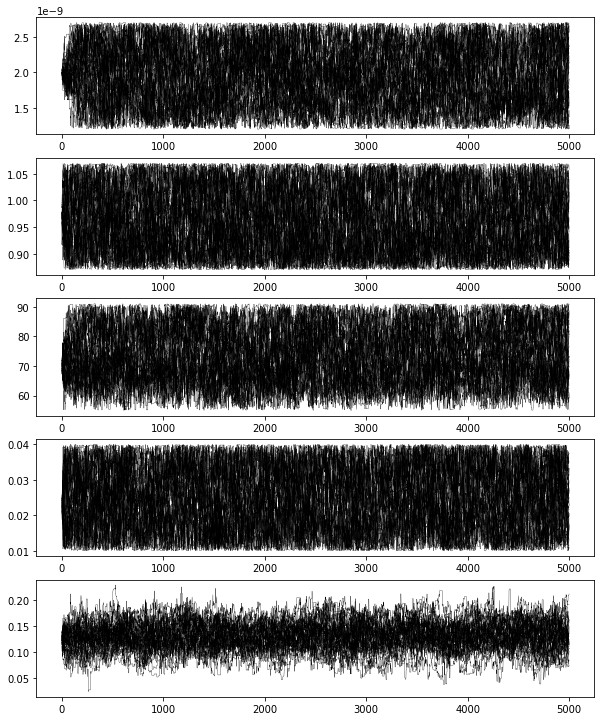

In [22]:
plot_emcee_chain(tempered_sampler, NDIM_SAMPLING)

In [23]:
N_BURN_IN = 3000
N_THIN    = 10

tempered_samples = tempered_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))

In [24]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from getdist import plots, MCSamples
import getdist


def plot_cosmo_contours(sample_list, legend_labels):
    names = ['As', 'ns', 'H0', 'omegab', 'omegac']
    labels =  ['As', 'ns', 'H0', 'omega b', 'omega c']
    
    cosmo_truth = [2e-9, 0.97, 69., 0.0228528, 0.1199772]
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True, markers=truth_dict)
    
    plt.show()

Removed no burn in


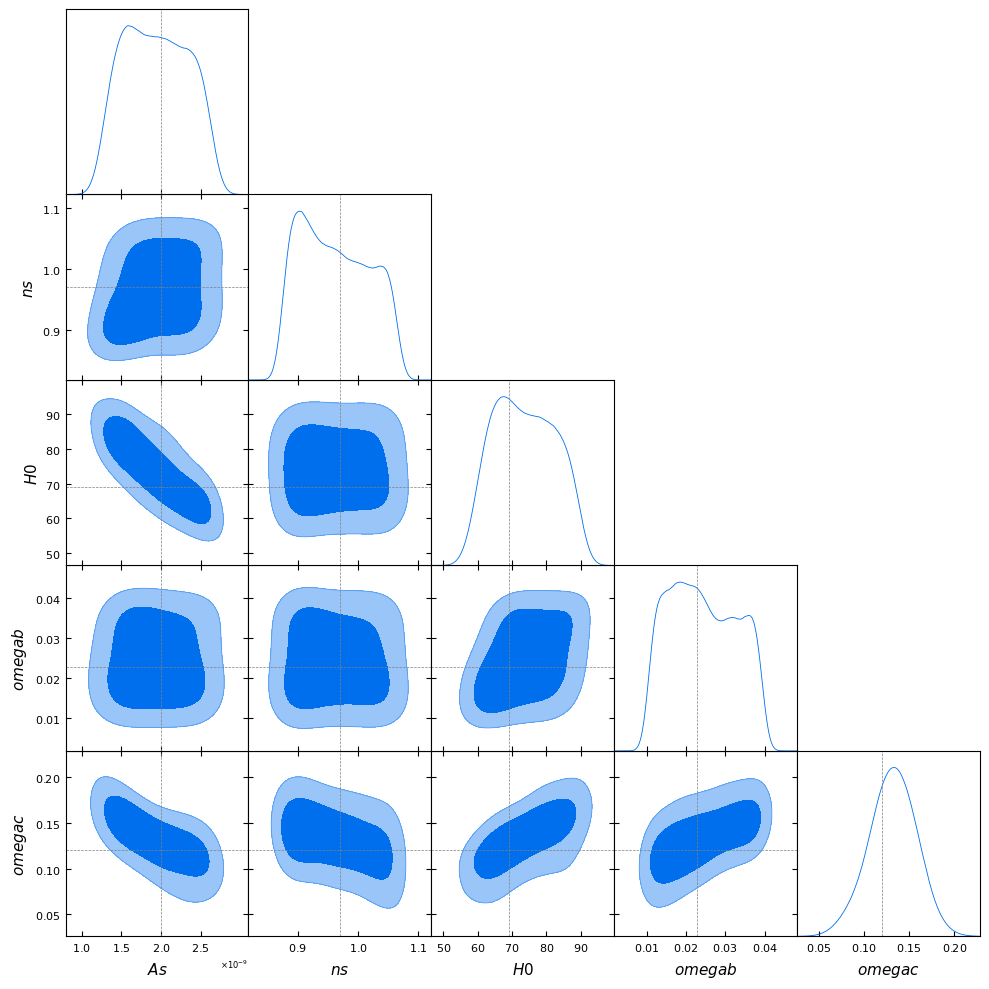

In [25]:
plot_cosmo_contours([tempered_samples], ['Tempered posterior'])

In [26]:
emu_sampler = sample_emu()

100%|██████████| 5000/5000 [00:37<00:00, 133.12it/s]


In [27]:
cosmo_samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))

In [28]:
np.save('output/iteration_0/tempered_samples.npy', tempered_samples)
np.save('output/iteration_0/cosmo_samples.npy',    cosmo_samples)

## Calculate the data vector for a subsample from the tempered posterior and retrain the emulator

Now we iteratively train the emulator, adding samples from the tempered posterior to the training data set at each iteration of the training. 

In [29]:
temper_schedule = [0.1, 0.2, 0.3, 0.5]   # Progressively decrease the temperature
N_resample      = 500
N_iterations    = 4

In [ ]:
for i in range(1, N_iterations+1):
    print("Iteration %d"%(i))
    select_indices      = np.random.choice(np.arange(len(tempered_samples)), size=N_resample, replace=False)
    train_cosmo_samples_current = tempered_samples[select_indices]
    if(i==1):
        # We do not use the samples from the LHS step
        train_cosmo_samples = train_cosmo_samples_current
    else:
        train_cosmo_samples = np.vstack([train_cosmo_samples, train_cosmo_samples_current])
    print("Calculating data vectors...")
    train_dv_arr        = calculate_datavector_batch(train_cosmo_samples)
    print("Training emulator...")
    emu                 = get_trained_nn_emu(train_cosmo_samples, train_dv_arr)
    print("Sampling tempered posterior...")
    tempered_sampler    = sample_emu(temper_schedule[i-1])
    tempered_samples    = tempered_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    print("Sampling posterior...")
    emu_sampler         = sample_emu()
    cosmo_samples       = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    np.save('output/iteration_%d/tempered_samples.npy'%(i), tempered_samples)
    np.save('output/iteration_%d/cosmo_samples.npy'%(i),    cosmo_samples)

Iteration 1
Calculating data vectors...


100%|██████████| 500/500 [03:15<00:00,  2.56it/s]


Training emulator...


Loss: 0.017661266028881073: 100%|██████████| 100/100 [02:09<00:00,  1.30s/it]

Sampling tempered posterior...



100%|██████████| 5000/5000 [00:39<00:00, 127.15it/s]


Sampling posterior...


100%|██████████| 5000/5000 [00:39<00:00, 128.14it/s]


Iteration 2
Calculating data vectors...


100%|██████████| 1000/1000 [06:26<00:00,  2.59it/s]


Training emulator...


Loss: 0.009972603991627693: 100%|██████████| 100/100 [11:13<00:00,  6.74s/it]

Sampling tempered posterior...



100%|██████████| 5000/5000 [01:29<00:00, 55.71it/s]

Sampling posterior...



100%|██████████| 5000/5000 [01:28<00:00, 56.82it/s]


Iteration 3
Calculating data vectors...


100%|██████████| 1500/1500 [09:40<00:00,  2.59it/s]


Training emulator...


Loss: 0.013957780785858631: 100%|██████████| 100/100 [21:59<00:00, 13.20s/it]

Sampling tempered posterior...



100%|██████████| 5000/5000 [01:36<00:00, 51.59it/s]


Sampling posterior...


100%|██████████| 5000/5000 [01:34<00:00, 52.70it/s]


Iteration 4
Calculating data vectors...


  5%|▍         | 93/2000 [00:38<08:01,  3.96it/s] 